In [28]:
import os
import pickle
import csv
from PIL import Image
import math

import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from sklearn.utils import shuffle

print('All modules imported.')

All modules imported.


In [29]:
# Load pickled data
training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"
signname_file = "signnames.csv"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(signname_file) as f:
    f.readline() # skip the headers
    signnames = [row[1] for row in csv.reader(f)]

# The images' pixels in [0, 255]
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [30]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = (X_train.shape[1], X_train.shape[2])
n_classes = len(signnames)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [31]:
# Visualizations will be shown in the notebook.
%matplotlib inline

# Show onw figure for each traffic sign
plt.figure(figsize=(250, 120))
plt.subplots_adjust(hspace = .1, wspace=.1)
for i in range(0, n_classes):
    index = np.where(y_train==i)[0][0]
    image = X_train[index]
    plt.subplot(5, 10, i + 1), plt.imshow(image)
    plt.xticks([]), plt.yticks([])
plt.savefig('./exploratory.jpg')

Text(0.5, 1.0, 'testing set distribution')

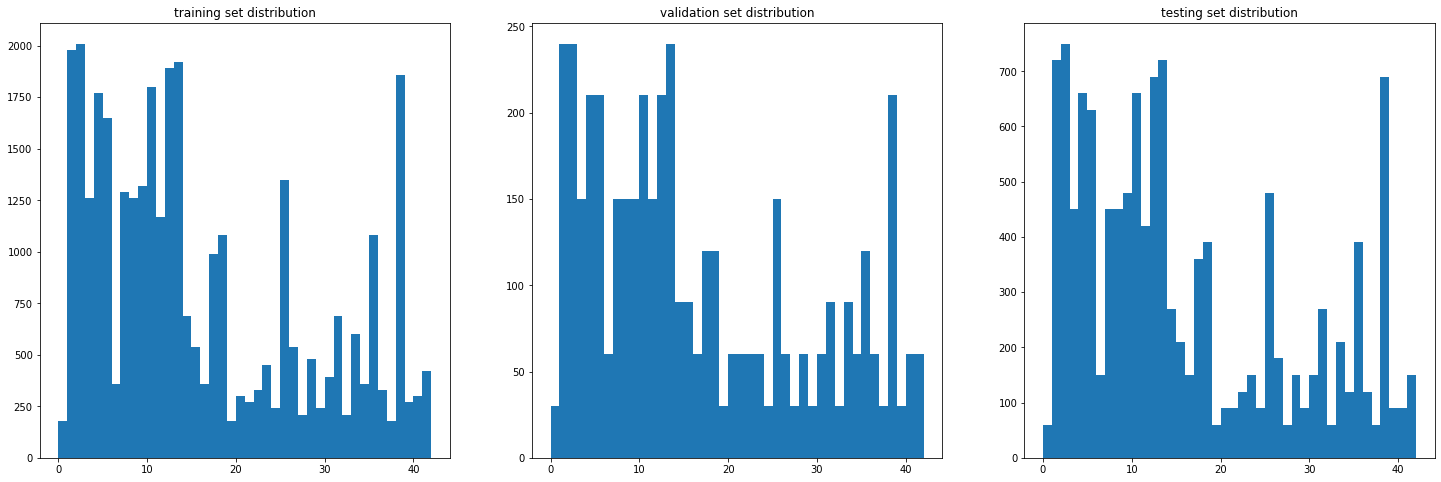

In [32]:
# Show hisgrom of the number of each traffic sign

fig, axes = plt.subplots(1, 3 ,figsize=(25, 8))
axes[0].hist(y_train, bins=range(0, n_classes))
axes[0].set_title('training set distribution')
axes[1].hist(y_valid, bins=range(0, n_classes))
axes[1].set_title('validation set distribution')
axes[2].hist(y_test, bins=range(0, n_classes))
axes[2].set_title('testing set distribution')

# plt.savefig('./distribution.jpg')

In [33]:
def normalize(image_set):
    return image_set.astype(np.float32) / 128. - 1.

def rgb2gray(image_set):
    new_set = np.array([])
    for img in image_set:
        np.append(new_set, cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return new_set

X_train =  normalize(X_train)
X_valid =  normalize(X_valid)
X_test =  normalize(X_test)

# X_train = rgb2gray(X_train)
# X_valid = rgb2gray(X_valid)
# X_test = rgb2gray(X_test)

print(X_train.shape, X_train.dtype)
print(X_valid.shape, X_valid.dtype)
print(X_test.shape, X_test.dtype)

(34799, 32, 32, 3) float32
(4410, 32, 32, 3) float32
(12630, 32, 32, 3) float32


In [34]:
# Save the data for easy access
pickle_file = 'pre-data.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_features': X_train,
                    'train_labels': y_train,
                    'valid_features': X_valid,
                    'valid_labels': y_valid,
                    'test_features': X_test,
                    'test_labels': y_test,
                    'signnames': signnames,
                },
                pfile, protocol=2)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


In [35]:
import tensorflow
print(tensorflow.__version__)

2.8.0


In [36]:
import os
import pickle
import math
import random
import csv
from PIL import Image

import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.utils import shuffle
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten

print('All modules imported.')

All modules imported.


In [19]:
# 1 Reload the preprocessed data

pickle_file = 'pre-data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_features']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_features']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_features']
    y_test = pickle_data['test_labels']
    signnames = pickle_data['signnames']
    del pickle_data  # Free up memory
    
# Shuffle the data set
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(signnames))
print('Data loaded.')

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43
Data loaded.


In [20]:
def LeNet(x, KEEP_PROB):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Input = 32x32x3. Output = 28x28x6.
    # Convolutional. 
    conv1_w = tf.Variable(tf.truncated_normal((5, 5, 3, 6), mu, sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, [1, 1, 1, 1], 'VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
       
    # Layer 2: Input = 14x14x6. Output = 10x10x16.
    # Convolutional. 
    conv2_w = tf.Variable(tf.truncated_normal((5, 5, 6, 16), mu, sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool1, conv2_w, [1, 1, 1, 1], 'VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
      
    # Flatten. Input = 5x5x16. Output = 400.
    flat = Flatten()(pool2)   
  
    # Layer 3: Input = 400. Output = 120.
    # Fully Connected. 
    full1_w = tf.Variable(tf.truncated_normal((400, 120), mu, sigma))
    full1_b = tf.Variable(tf.zeros(120))
    full1 = tf.matmul(flat, full1_w) + full1_b
    # Activation.
    full1 = tf.nn.relu(full1) 
    # Dropout
    full1 = tf.nn.dropout(full1, KEEP_PROB)
    
    # Layer 4: Input = 120. Output = 84.
    # Fully Connected. 
    full2_w = tf.Variable(tf.truncated_normal((120, 84), mu, sigma))
    full2_b = tf.Variable(tf.zeros(84))
    full2 = tf.matmul(full1, full2_w) + full2_b
    # Activation.
    full2 = tf.nn.relu(full2)
    # Dropout
    full2 = tf.nn.dropout(full2, KEEP_PROB)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    full3_w = tf.Variable(tf.truncated_normal((84, 43), mu, sigma))
    full3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(full2, full3_w) + full3_b
    
    return logits

In [21]:
# Placeholder
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder_with_default(1.0, shape=())

# Hyperparameters
LEARNING_RATE = 1e-2
EPOCHS = 10
BATCH_SIZE = 128

# Train method
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [22]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples, loss

Training...
EPOCH 1 : Validation Accuracy = 0.058
EPOCH 2 : Validation Accuracy = 0.145
EPOCH 3 : Validation Accuracy = 0.170
EPOCH 4 : Validation Accuracy = 0.231
EPOCH 5 : Validation Accuracy = 0.288
EPOCH 6 : Validation Accuracy = 0.341
EPOCH 7 : Validation Accuracy = 0.380
EPOCH 8 : Validation Accuracy = 0.395
EPOCH 9 : Validation Accuracy = 0.427
EPOCH 10 : Validation Accuracy = 0.432
Model saved


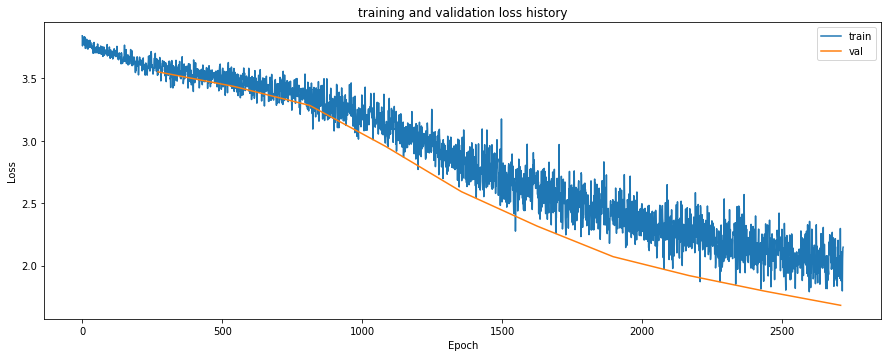

CPU times: total: 14min 9s
Wall time: 4min 22s


In [24]:
%%time
# 2min 7s
train_losses = []
valid_losses = []
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        print("EPOCH {} :".format(i+1), end=' ')
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, train_loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            train_losses.append(train_loss)
        validation_accuracy, valid_loss = evaluate(X_valid, y_valid)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        valid_losses.append(valid_loss)
                
    saver.save(sess, 'model/lenet.ckpt')
    print("Model saved")
    
plt.subplot(2, 1, 2)
plt.plot(train_losses, label='train')
plt.plot([(i+1) * int(num_examples / BATCH_SIZE) for i in range(EPOCHS)], valid_losses, label='val')
plt.title('training and validation loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gcf().set_size_inches(15, 12)
plt.legend()
plt.show()

INFO:tensorflow:Restoring parameters from ./model/lenet.ckpt


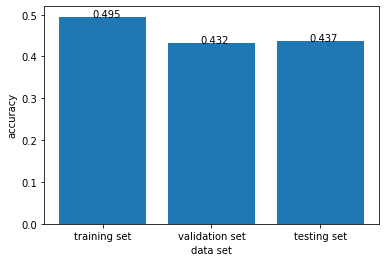

In [25]:
with tf.Session() as sess:
    saver.restore(sess, './model/lenet.ckpt')
    train_accuracy,_ = evaluate(X_train, y_train)
    valid_accuracy,_ = evaluate(X_valid, y_valid)
    test_accuracy,_ = evaluate(X_test, y_test)
    
accuracys = [train_accuracy, valid_accuracy, test_accuracy]
tick_labels = ["training set", "validation set", "testing set"]
plt.bar(range(3), accuracys)
plt.xlabel('data set')
plt.ylabel('accuracy')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.show()

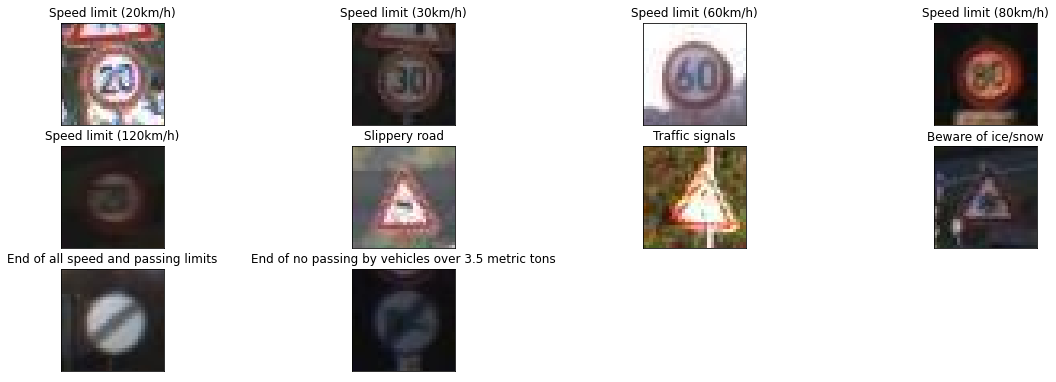

In [41]:
gt_images = []
gt_labels = []

with open('./test_images/labels.csv') as f:
    gt_labels = [row[7] for row in csv.reader(f)]
# print(gt_labels)

for i in range(1, 11):
    img = Image.open('./test_images/' + str(i) +'.jpg')
    img.save('./test_images/' + str(i) +'.jpg')
    gt_images.append(plt.imread('./test_images/' + str(i) +'.jpg'))
# print(gt_images)

plt.figure(figsize=(20, 20))
for i in range(len(gt_images)):
    plt.subplot(9, 4, i + 1), plt.imshow(gt_images[i]), plt.title(signnames[int(gt_labels[i])])
    plt.xticks([]), plt.yticks([])
    
gt_images = np.array(gt_images)
gt_labels = np.array(gt_labels)
    
# Normalization
gt_images = gt_images.astype(np.float32) / 128. - 1.

In [40]:
with tf.Session() as sess:
    saver.restore(sess, './model/lenet.ckpt')
    test_accuracy = evaluate(gt_images, gt_labels)
    print("Test Accuracy =", test_accuracy)   
    logits_value = sess.run(logits, feed_dict={x: gt_images})
    probabilities = sess.run(tf.nn.softmax(logits_value))
    
predict = probabilities.argmax(axis=1)
print("Predict the Sign Type for Each Image")
print(predict)

INFO:tensorflow:Restoring parameters from ./model/lenet.ckpt
Test Accuracy = (0.0, 3.1031141)
Predict the Sign Type for Each Image
[ 1  2  2 10 10 11  5 18  5  5]


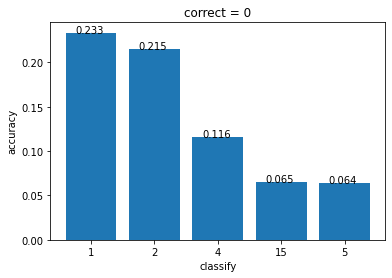

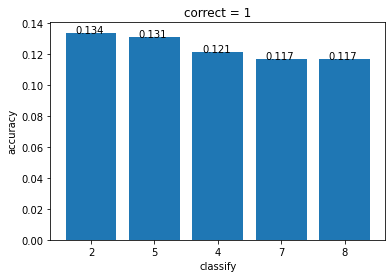

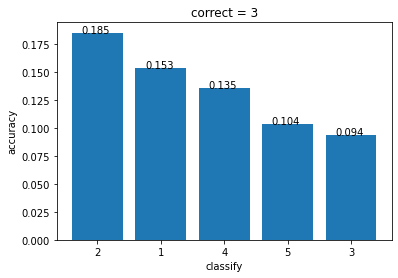

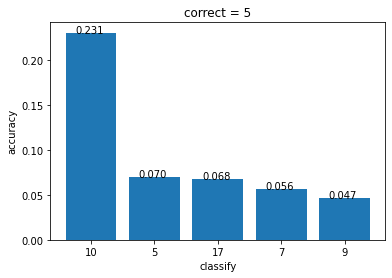

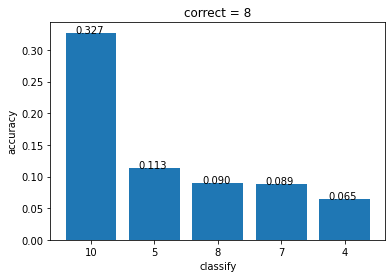

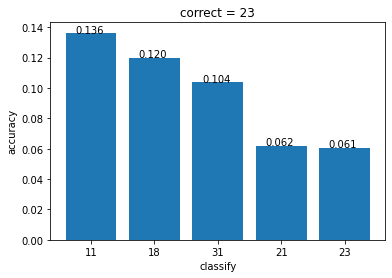

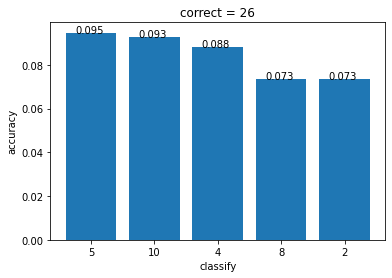

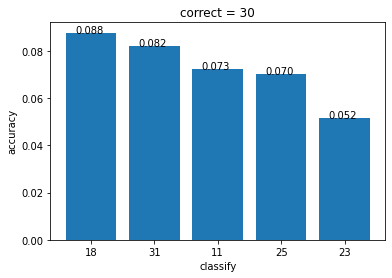

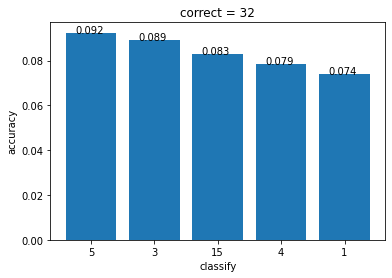

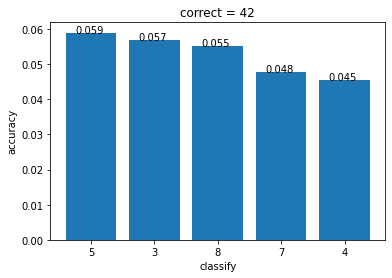

In [45]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.constant(probabilities), k=5))

def plt_bar(values, indicex, answer):
    plt.bar(range(5), values)
    plt.xlabel('classify')
    plt.ylabel('accuracy')
    plt.xticks(range(5), indicex)
    plt.title("correct = "+answer)
    for x_,y_ in zip(range(5), values):
        plt.text(x_ - 0.25, y_, '%.3f'%y_)
    plt.show()

for i in range(10):
    plt_bar(top5.values[i], top5.indices[i], gt_labels[i])